# Numerical Methods Example

## Problem Outline

A classic example, known as the 1D advection equation.
Advection is the transport of some chemical (or any quantity really) by a fluid with a given velocity.

Our goal is to determine the concentration distribution over time.

We introduce the following variables:
- $t:$ time!
- $x:$ this represents the position in space, e.g. in a pipe or column.
In theory, we could consider more coordinates, but this adds complexity.
- $c:$ this is the concentration of the chemical being 'carried' by the fluid.
The concentration varies with space, $x$, and over time, $t$.
In general, this could be any quantity, e.g. mass.
- $\nu:$ the velocity of the fluid.
Can vary with time, $t$, and space, $x$.

We will consider a pipe with a fixed length, L.

To simplify the problem we make the following assumptions:

- The velocity of the fluid is constant (i.e. it doesn't change over time, $t$, and is the same at all positions, $x$).
- Diffusion of the chemical in the fluid is negligible.
- Concentration is small enough so that it doesn't affect the motion of the fluid.

Based on the above we can derive the following hyperbolic partial differential equation (PDE):

$$
\frac{\mathrm{d}c(x, t)}{\mathrm{d}t} + \nu\frac{\mathrm{d}c}{\mathrm{d}x}=0
$$


### Initial and boundary conditions

The equation above only tells us how concentration evolves with time and space.
To solve it, we need the following:
- what the concentration is at the start (initial condition).
- what the concentration at the boundaries of the space we are considering (boundary condition/s).

We'll make the following assumptions
- The pipe is devoid of chemical at the start, i.e. $c(x,t=0)=0$.
This is our initial condition.
- The pipe is constantly fed with a fixed concentration of material, $c_B$.
This is our first boundary condition.
- The pipe opens up to the  

## Solution

Before rushing to code, let's think about how we are going to solve the problem.
A graphical way to do this is using a flowchart of the algorithm we will implement.
Our algorithm will just be an overview of the instructions we will give the computer.

<div style="text-align: center; background-color: white; display: inline-block;">
    <img src="images/flowchart_TA_example.svg" alt="Alt text">
</div>

### Initialization

First we must import the libraries we are going to be using:
- NumPy: you'll see this in a lot of scientific programs. It's very similar in efficiency to matlab.
- Scipy: a popular library that has ODE solvers for us to use out-of-the-box.
- MatPlotLib: this will allow us to visualise our data using plots and animations. It's designed to be very similar to matlab.

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

We can then move on to defining our inputs

In [18]:
# inputs:
# initial condition
initialConcentration = 0.0 # this represents the concentration everywhere, c(x, t=0)

# operating conditions
velocity = 2.0 # [m/s] - could be any units, as long as we are consistent!
feedConcentration = 8.0 # [mol/m3] - also our boundary condition

# Grid definition
columnStart = 0.0 # [m] - this is just a reference, could be any value
columnEnd = 30 # [m]
gridSpacing = 0.01 # [m] - the distance between the finite difference points
# ! what will happen if we increase the grid spacing?

# time span
timeSpan = (0, 40) # [s]

we should use the grid definition to discretize our initial condition

In [3]:
# discretize the domain - divide the column into discrete lengths
lengthArray = np.arange(columnStart, columnEnd+gridSpacing, gridSpacing)

# discretize the initial distribution of concentration in the column
initialConcentrationDistribution = np.full_like(lengthArray, initialConcentration)

we add a ghost cell to the start of the distribution.
This will represent our boundary condition (feed concentration).

### Numerical Solution

First, we define our ode system.
SciPy has a particular format it wants the ode system in that we must follow.

#### ODE system loop

Our first attempt at defining our ODE system might look something like this

In [4]:
def ODEsystem(t, y, velocity:float, lengthArray: np.ndarray,
              feedConcentration:float):
    # unpack the state
    concentrationDistribution = y
    
    # determine the number of points in the column
    numberOfPoints = lengthArray.size
    
    # initialize an array to store derivatives
    dydt = np.zeros(numberOfPoints)
    
    # calculate the grid spacing
    gridSpacing = lengthArray[1]-lengthArray[0]
    
    # determine the derivative at the boundary
    dydt[0] = velocity * (
        feedConcentration - concentrationDistribution[0]) / gridSpacing
    
    # determine the derivatives for the interior points
    for i in range(1, numberOfPoints):
        dydt[i] = velocity * (
            concentrationDistribution[i-1] - concentrationDistribution[i]
        ) / gridSpacing
    
    return dydt

The problem with the above is that Python ODEs are incredibly slow.
Fortunately, NumPy helps us by doing vectorization.

#### Vectorized ODE system (efficient)

In [6]:
def ODEsystem(t, y, velocity:float, lengthArray:np.ndarray,
              feedConcentration:float):
    # add ghost cells (boundary conditions) to current state
    concentrationDistribution = np.insert(y, 0, feedConcentration)
    
    # determine number of points in the column
    numberOfPoints = lengthArray.size
    
    # initialize an array to store derivatives
    dydt = np.zeros(numberOfPoints)
    
    # calculate the grid spacing
    gridSpacing = lengthArray[1] - lengthArray[0]
    
    # generate the derivatives using finite difference
    dydt = velocity * (concentrationDistribution[:-1] - concentrationDistribution[1:]) / gridSpacing
    
    return dydt

We now have everything in place to use the SciPy solver

In [19]:
# solve the ode system
solution = solve_ivp(ODEsystem, timeSpan, initialConcentrationDistribution,
                     args=(velocity, lengthArray, feedConcentration),
                     method='BDF')

# extract solution
time = solution.t
concentrationDistributions = solution.y

## Analytical Solution

For the simple problem we have considered, there exists an analytical solution we can compare with:
$$x$$

## Visualisation

### Animation

We can animate the evolution of the concentration distribution over time.

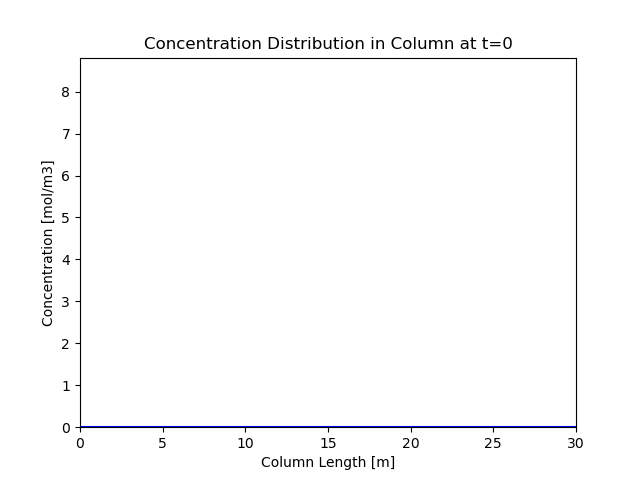

In [20]:
%matplotlib widget

plt.close('all')

# set up the figure and axes with initial frame
figure, axes = plt.subplots()
line, = axes.plot(lengthArray, concentrationDistributions[:, 0], color='b')
axes.set_xlim(columnStart, columnEnd)
axes.set_ylim(np.min(concentrationDistributions), 1.1*np.max(concentrationDistributions))
axes.set_xlabel('Column Length [m]')
axes.set_ylabel('Concentration [mol/m3]')
axes.set_title('Concentration Distribution in Column at t=0')

# initialization function: plot the background of each frame
def init():
    line.set_ydata(np.ma.array(lengthArray, mask=True))
    return line,

# update function: this is called for each frame to update the plot
def update(frame):
    line.set_ydata(concentrationDistributions[:, frame])
    axes.set_title(f'Concentration Distribution in Column at t={time[frame]:.2f}')
    return line,

# create the animation
animation = FuncAnimation(figure, update, frames=len(time),
                          init_func=init, blit=True, repeat=False)